# Text Analysis

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "1"

from utils.analysis_helpers import *
from utils.clusters_helpers import *

c:\Users\david\anaconda3\envs\basic\lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


## Choose features of the data to analyse
- Drop or select specifics conditions
- Differentiate between interviwer & participant

In [8]:
directory = '../interviews_corrected/6_final/**/' 

df_all = load_and_combine_csv(directory)
df_all = standardize_data(df_all)
df_all = calculate_word_char_counts(df_all)

df_all.to_csv("outputs/combined_data.csv", index=False)

Found 82 CSV files.
Standardized speaker labels.
Normalized text in 'Content' column.
Calculated 'Word_Count' and 'Character_Count' for each response.


In [5]:
print(df_all["Condition"].unique())
# Drop the rows equal to 0 for the column condition
df_all = df_all[df_all["Condition"] != 0]
print(df_all["Condition"].unique())

[1 'C' 'I' 0]
[1 'C' 'I']


In [6]:
# If only want to focus on participant speaker
df_participant = df_all[df_all["Speaker"] == "Participant"].copy()
df_interviewer = df_all[df_all["Speaker"] == "Interviewer"].copy()

## Word Count

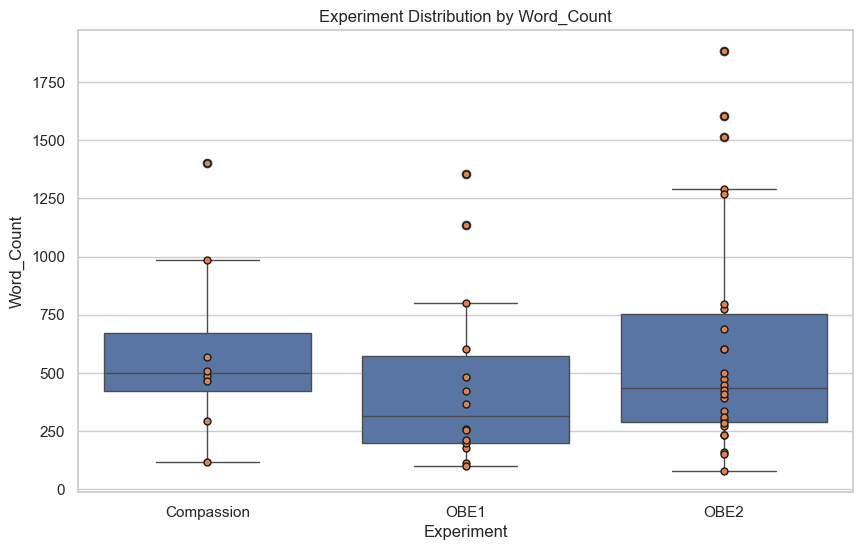

In [7]:
stripplot(aggregate_counts(df_participant,["Experiment","Id"]), 'Experiment', 'Word_Count')

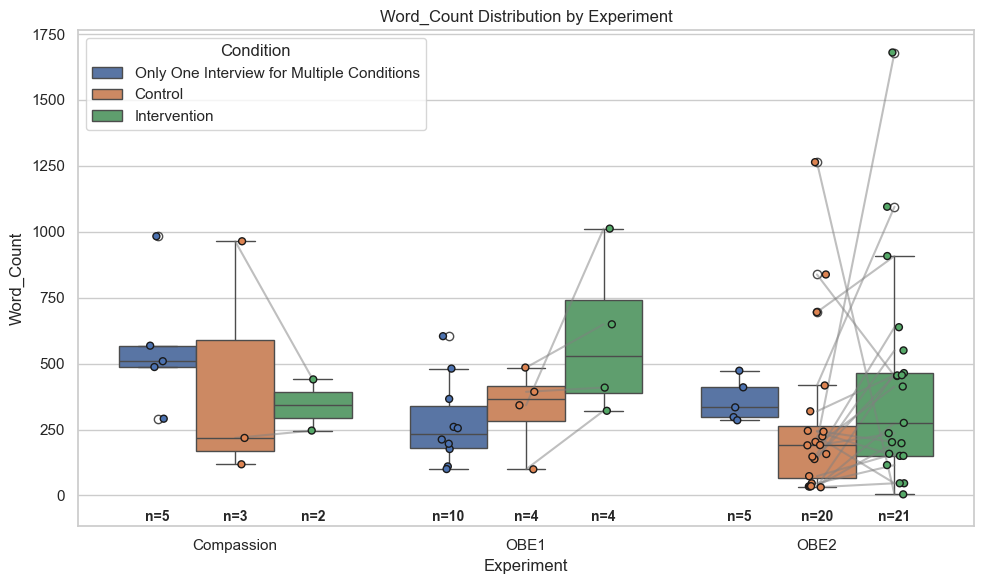

In [8]:
# Group by Id instead of File Name because the same participant can have the same condition in different interviews
stripplot_with_counts(aggregate_counts(df_participant, ['Experiment', "Id", "Condition"]), 'Experiment', 'Word_Count', 
                      hue_column='Condition', id_column="Id", legend_labels=["Only One Interview for Multiple Conditions","Control","Intervention"])#,file_name="stripplot_word_count_id.png")

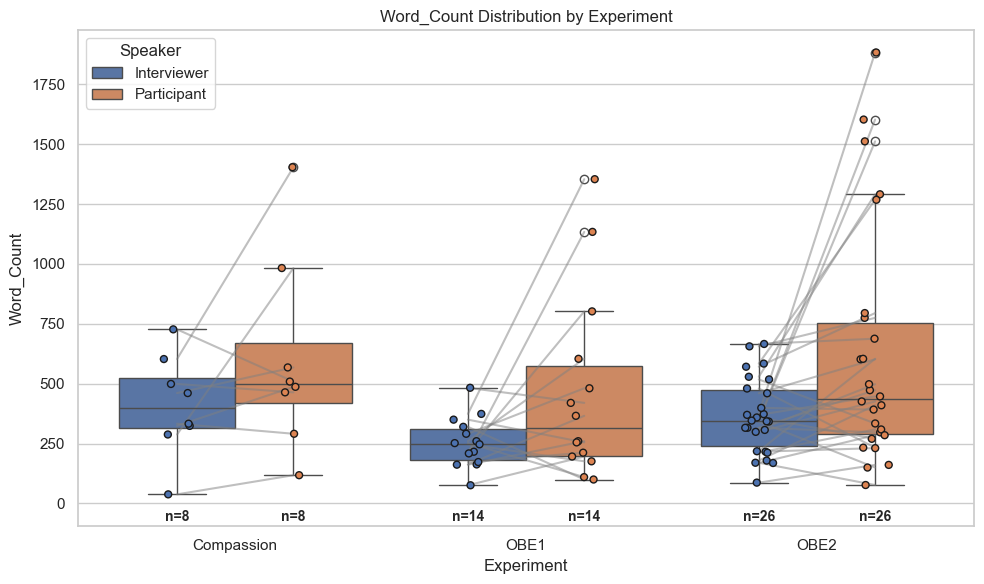

In [9]:
stripplot_with_counts(aggregate_counts(df_all, ['Experiment', "Id", 'Speaker']), 'Experiment', 'Word_Count', hue_column='Speaker', id_column="Id")

<Figure size 1200x600 with 0 Axes>

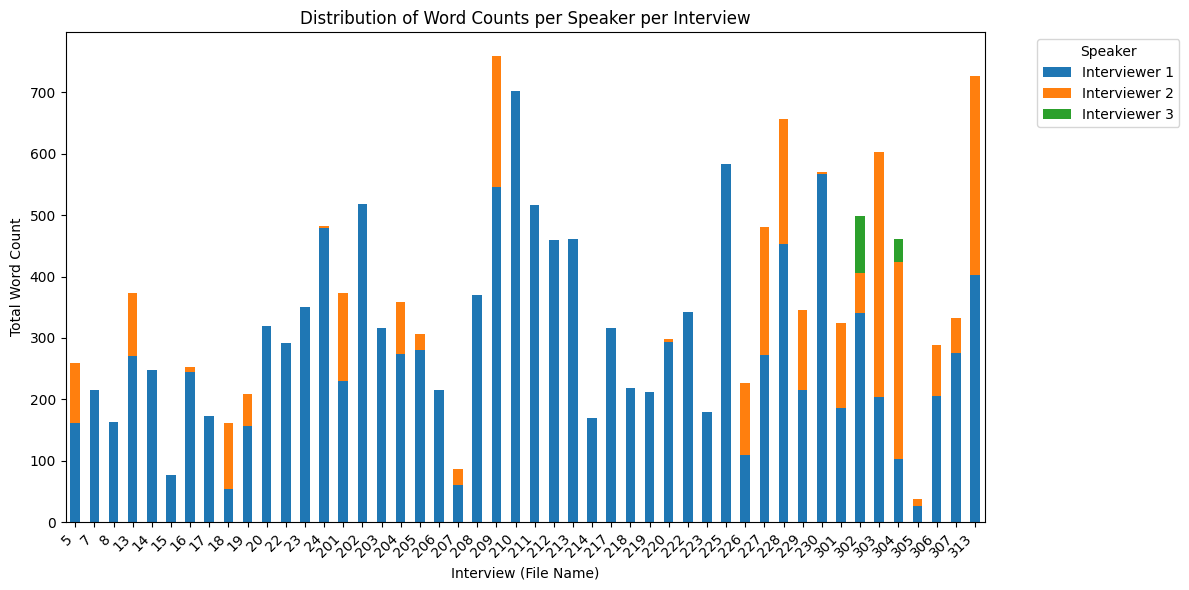

In [20]:
# Group by file name and speaker, summing word counts
word_count_summary = df_all.groupby(['Id', 'Speaker_original'])['Word_Count'].sum().reset_index()
word_count_summary = word_count_summary[word_count_summary["Speaker_original"] != "Participant"]

# Create a pivot table for better visualization
word_count_pivot = word_count_summary.pivot(index='Id', columns='Speaker_original', values='Word_Count').fillna(0)

# Plotting the distribution of word counts
plt.figure(figsize=(12, 6))
word_count_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Distribution of Word Counts per Speaker per Interview")
plt.xlabel("Interview (File Name)")
plt.ylabel("Total Word Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Speaker", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

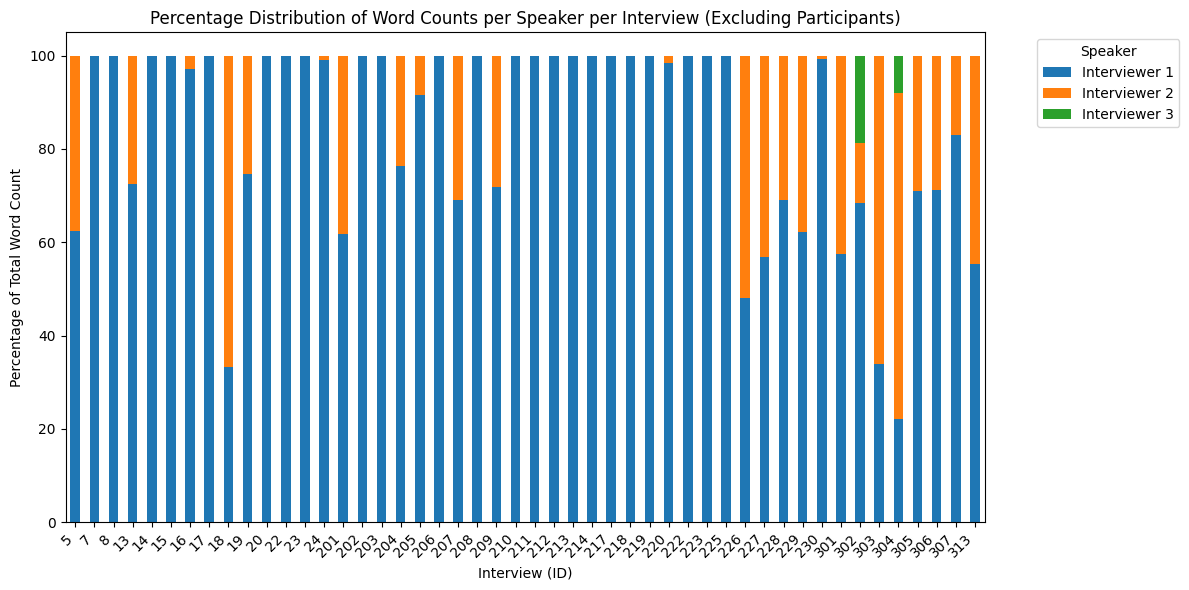

In [26]:
# Calculate percentage of total word counts for each speaker per ID (excluding participants)
word_count_summary = df_all.groupby(['Id', 'Speaker_original'])['Word_Count'].sum().reset_index()
word_count_summary = word_count_summary[word_count_summary["Speaker_original"] != "Participant"]

# Calculate the total word count per ID for normalization
total_word_counts = word_count_summary.groupby('Id')['Word_Count'].sum().reset_index()
total_word_counts.rename(columns={'Word_Count': 'Total Word Count'}, inplace=True)

# Merge back to compute percentages
word_count_summary = word_count_summary.merge(total_word_counts, on='Id')
word_count_summary['Percentage'] = (word_count_summary['Word_Count'] / word_count_summary['Total Word Count']) * 100

# Create a pivot table for better visualization
percentage_pivot = word_count_summary.pivot(index='Id', columns='Speaker_original', values='Percentage').fillna(0)

# Plotting the percentage distribution of word counts
plt.figure(figsize=(12, 6))
percentage_pivot.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title("Percentage Distribution of Word Counts per Speaker per Interview (Excluding Participants)")
plt.xlabel("Interview (ID)")
plt.ylabel("Percentage of Total Word Count")
plt.xticks(rotation=45, ha='right')
plt.legend(title="Speaker", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


## Frequency & Unique Words

In [10]:
extra_words = ["yeah", "like", "think", "know", "dont","yes", "one","okay","mm", "really","bit","could","thats","see","feel","felt"] 

df_participant['preprocessed_content'] = df_participant['Content'].apply(lambda x: preprocess_text(x, extra_stopwords=extra_words))

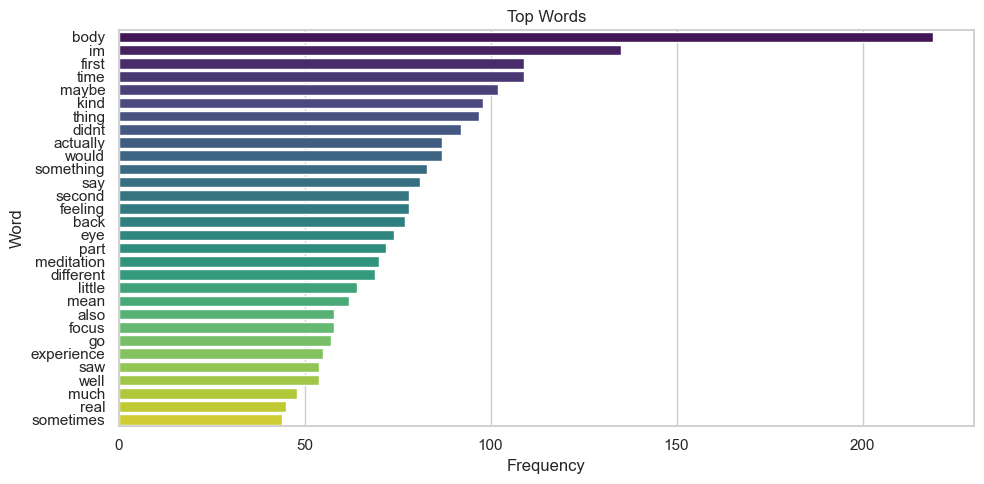

In [11]:
word_frequency_analysis(df_participant, top_n=30) #groupby_column=["Experiment"])

In [12]:
# You can specify any list of columns for grouping, e.g., ['Experiment', 'Condition']
unique_words_df_participant = count_unique_words(df_participant, groupby_columns=['Experiment', 'Condition'])
unique_words_df_participant = unique_words_df_participant.sort_values(by='Participant_Count', ascending=False)
unique_words_df_participant.to_csv("outputs/unique_words_participant.csv", index=False)

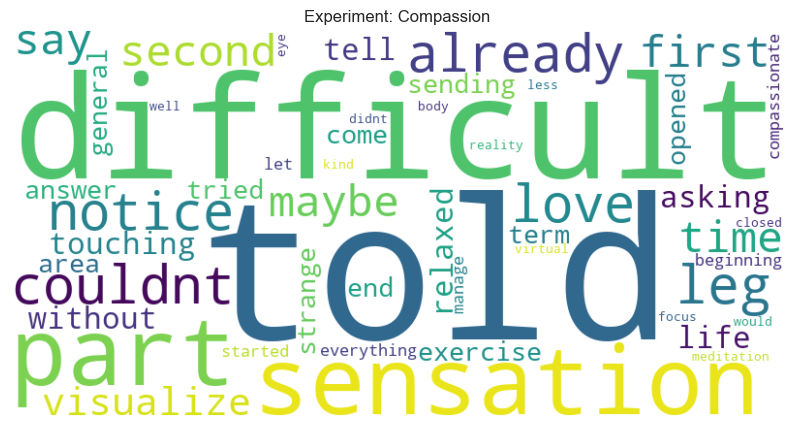

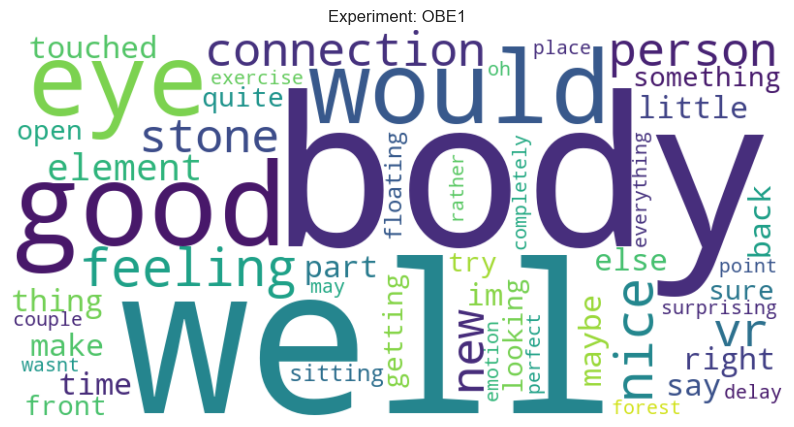

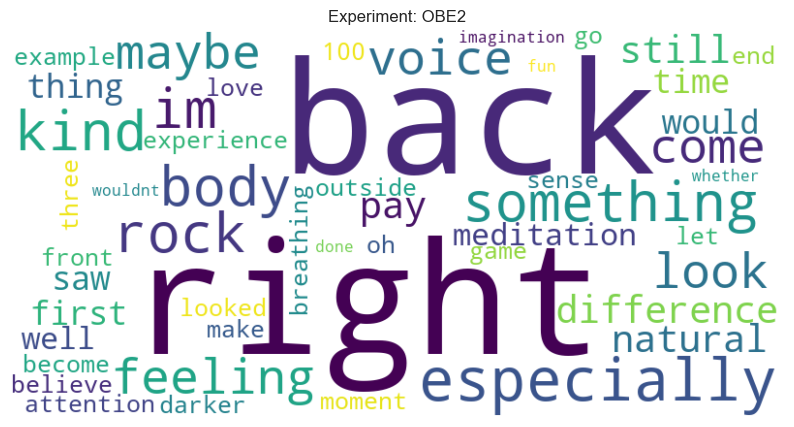

In [13]:
generate_word_clouds(unique_words_df_participant, groupby_columns=['Experiment'])

## Clusters

In [14]:
#df = df_all[df_all["Speaker"] == "Interviewer"].copy()
df = df_all[df_all["Speaker"] == "Participant"].copy()

# I want to select only one experiment
df = df[df["Experiment"] == "OBE2"]

In [15]:
# Define extra stopwords
extra_stopwords = {'yeah', 'yes', 'like', 'you', 'know', 'um', 'uh', 'dont', 'really'}

# Preprocess the text
df['preprocessed_content'] = df['Content'].apply(
    lambda x: preprocess_text(x, extra_stopwords=None, ngrams=2)
)

grouped_df = df.groupby('Id').agg({
    'preprocessed_content': ' '.join,  # Combine preprocessed text
    'Experiment': 'first',             # Keep the first (consistent if File Name is unique)         
}).reset_index()

In [16]:
grouped_df

,Id,preprocessed_content,Experiment
0,201,beginning_control control_put put_attention at...,OBE2
1,202,interesting_feel feel_outside outside_mind y...,OBE2
2,203,feeling_body body_touch touch_body body_see se...,OBE2
3,204,okay_creepy observing_body body_seeing seeing...,OBE2
4,205,yes_yes yes_super super_nice really_relaxing w...,OBE2
5,206,feel_sleepy think_beginning beginning_certain ...,OBE2
6,207,part_could could_see see_body body_back back_b...,OBE2
7,208,actually_noticed noticed_there unless_go go_s...,OBE2
8,209,moment_feel feel_mismatch yeah_thinking think...,OBE2
9,210,yeah_really really_nice really_like like_also ...,OBE2


In [17]:
embeddings_tf = embed_text_tfidf(grouped_df['preprocessed_content'].tolist())  # For TF-IDF
embeddings_bert = embed_text_bert(grouped_df['preprocessed_content'].tolist())  # For BERT

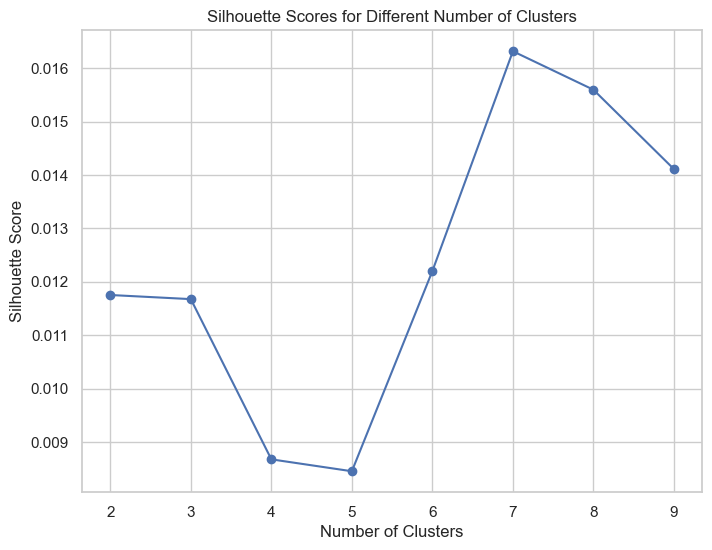

Optimal number of clusters: 7


In [18]:
find_optimal_clusters(embeddings_tf)

In [19]:
cluster_labels, kmeans_model = cluster_text_kmeans(embeddings_tf, 2)

df_tf = grouped_df.copy()
df_tf['Cluster'] = cluster_labels
df_tf["Embedding"] = embeddings_tf.tolist()

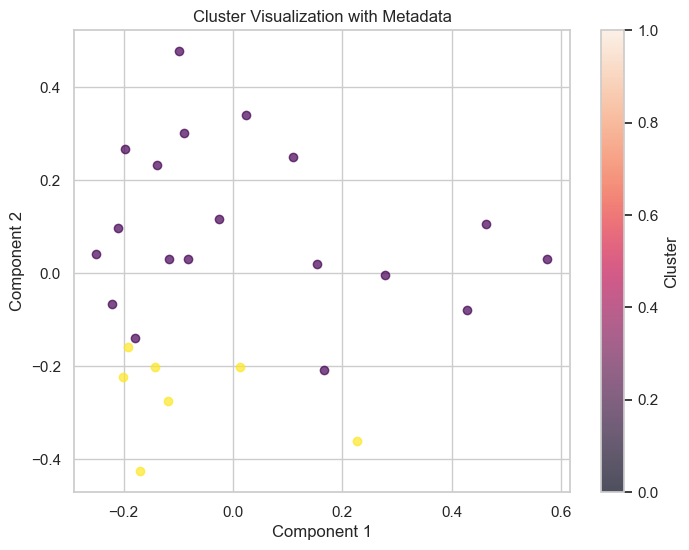

In [20]:
visualize_clusters_from_df(
    df=df_tf,
    n_components=2,
)

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List

def visualize_metadata_distribution(
    df: pd.DataFrame,
    cluster_col: str = 'Cluster',
    metadata_cols: List[str] = [],
    title_prefix: str = 'Metadata Distribution by Cluster'
):
    """
    Visualizes the distribution of selected metadata columns across clusters.

    Parameters:
    - df (pd.DataFrame): DataFrame containing clusters and metadata.
    - cluster_col (str): Column name for cluster labels (default: 'Cluster').
    - metadata_cols (List[str]): List of metadata column names to visualize.
    - title_prefix (str): Prefix for the plot titles.

    Output:
    - Displays a bar plot for each metadata column showing its distribution by cluster.
    """
    # Check if cluster column exists
    if cluster_col not in df.columns:
        raise ValueError(f"'{cluster_col}' column not found in the DataFrame.")

    # Check if metadata columns exist
    missing_cols = [col for col in metadata_cols if col not in df.columns]
    if missing_cols:
        raise ValueError(f"The following metadata columns are missing: {', '.join(missing_cols)}")

    # Iterate over metadata columns and plot
    for meta_col in metadata_cols:
        # Group data by cluster and metadata column
        grouped = df.groupby([cluster_col, meta_col]).size().reset_index(name='Count')

        # Plot
        plt.figure(figsize=(10, 6))
        sns.barplot(
            data=grouped,
            x=cluster_col,
            y='Count',
            hue=meta_col,
            palette='viridis'
        )
        plt.title(f'{title_prefix}: {meta_col}')
        plt.xlabel('Cluster')
        plt.ylabel('Count')
        plt.legend(title=meta_col, loc='upper right')
        plt.show()


In [22]:
visualize_metadata_distribution(df_tf, metadata_cols=['Condition', 'Experiment'])

ValueError: The following metadata columns are missing: Condition

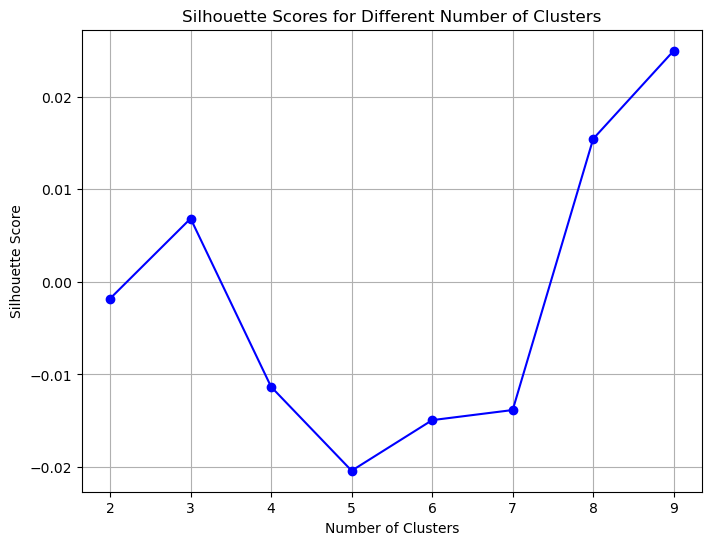

Optimal number of clusters: 9


In [ ]:
find_optimal_clusters(embeddings_bert)

In [ ]:
cluster_labels, kmeans_model = cluster_text_kmeans(embeddings_bert, 2)

df_bert = grouped_df.copy()
df_bert['Cluster'] = cluster_labels
df_bert["Embedding"] = embeddings_bert.tolist()

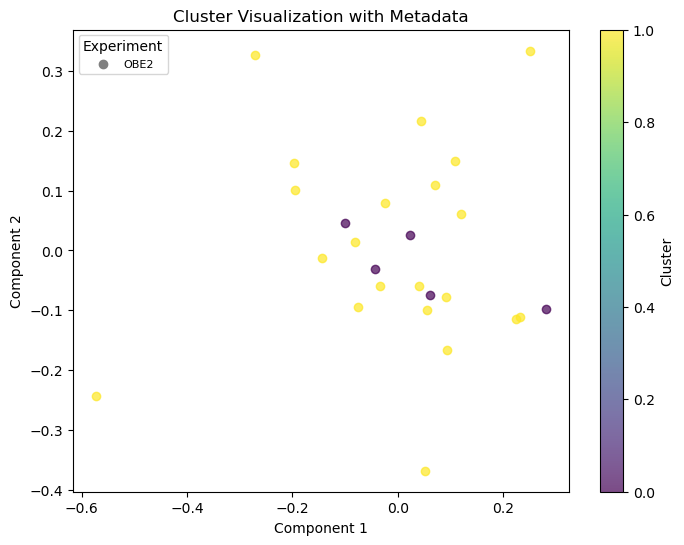

In [ ]:
visualize_clusters_from_df(
    df=df_bert,
    shape_by='Experiment',  # Optional
    n_components=2,
)

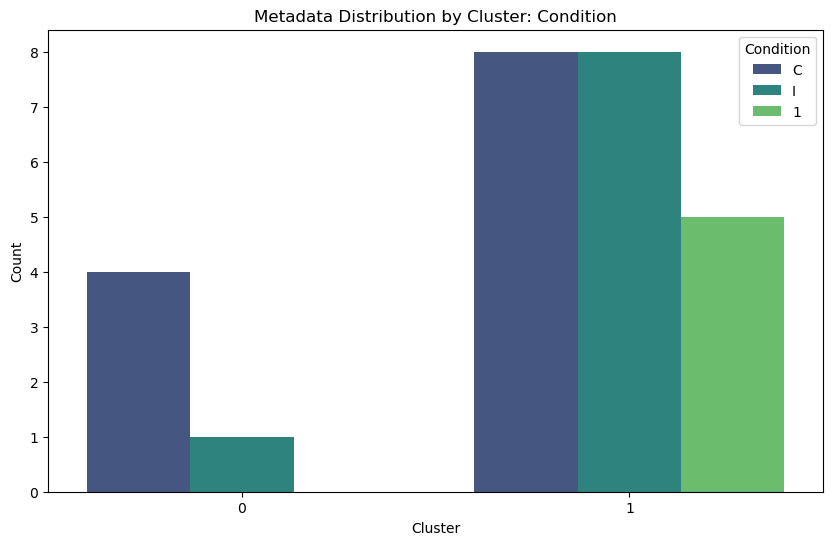

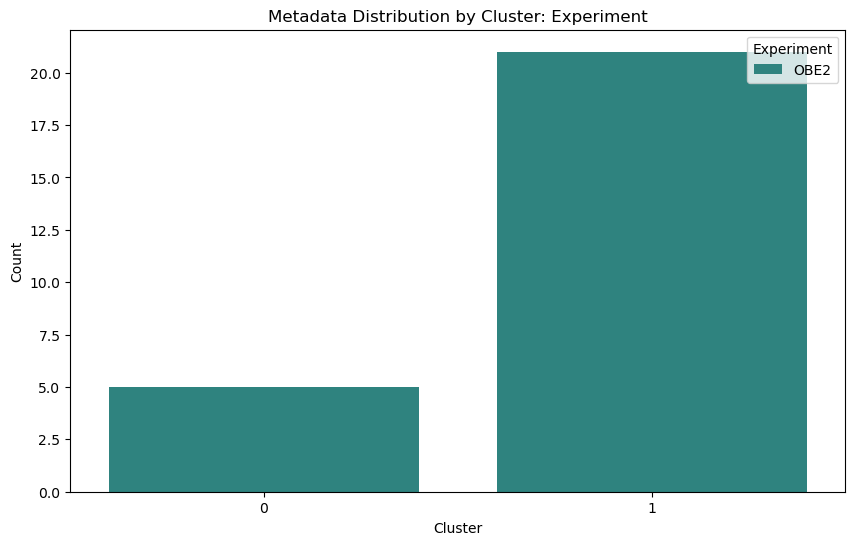

In [ ]:
visualize_metadata_distribution(df_bert, metadata_cols=['Condition', 'Experiment'])

### DBSCAN

In [ ]:
from sklearn.cluster import DBSCAN

# Perform DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5, metric='cosine')
labels = dbscan.fit_predict(embeddings_tf)

# Identify noise points (-1)
num_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"Number of clusters: {num_clusters}")


Number of clusters: 0
